In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [35]:
# Код нейронной сети в Keras!
###############################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam

from tensorflow.keras.losses import CategoricalCrossentropy
# keras.losses.categorical_crossentropy()
# from tensorflow.keras.metrics import accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [11]:
(train_imagesi,train_labels),(test_imagesi,test_labels)=fashion_mnist.load_data()

# приведем изображение к диапазону (-1,1).
train_images = (train_imagesi / 127) - 1
test_images = (test_imagesi / 127) - 1

# делаем векторизацию, т.к. наши слои полносвязные и хотят на вход вектор.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

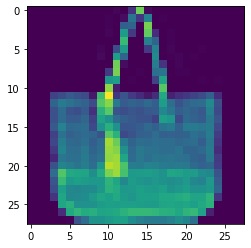

8


In [12]:
plt.imshow(train_imagesi[35,:,:])
plt.show()
print(train_labels[35])

In [13]:
train_labels[:100]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1,
       4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5,
       9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2,
       0, 0, 4, 1, 3, 1, 6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7,
       9, 9, 9, 3, 2, 9, 3, 6, 4, 1, 1, 8], dtype=uint8)

In [14]:
train_images[202,150:160]

array([-0.5984252 , -0.62204724, -0.64566929, -0.56692913, -0.59055118,
       -0.62992126, -0.61417323, -0.61417323, -0.66929134, -0.58267717])

In [15]:
# Размер набора данных для обучения
train_images.shape

(60000, 784)

## 1. Опишите - какой результата получен в нейросети в зависимости от:
## - числа нейронов в слое(для 2-хслойной сети),
## - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
## фиксируйте для тренировочного и тестового набора метрики accuracy.

In [16]:
#Собираем сеть по слоям через .add()
model = Sequential(name='2_layer_model')
model.add(Dense(128, activation='relu', input_shape=(784,)))  
# входной слой + поносвязный слой из 128 нейронов с активацией ReLU
model.add(Dense(10, activation='tanh')) 
# Скрытый слой 10 нейронов с активацией tanh
model.add(Dense(10, activation='softmax')) 
# выходной слой из 10 нейронов (сколько классов, столько нейронов) + активация softmax

# Компилируем сеть с оптимизатором Adam (нам на данный момент интересно влияние количества нейронов), функцией потерь и метрикой:
model.compile(
  optimizer='adam', # оптимизатор
  loss=CategoricalCrossentropy(), # функция потерь
  metrics=['accuracy'], # метрика
) 

In [17]:
model.summary()

Model: "2_layer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
Total params: 101,880
Trainable params: 101,880
Non-trainable params: 0
_________________________________________________________________


**101 880** параметров в сети. Все будем обучать.

Как считать параметры слоя: (число входов нейрона +1)*число нейронов


Например, для 5 входов и 10 нейронов в слое - число настраиваемых параметров = (5+1)*10 = 60

In [18]:
# Превратим выходы в векторые (OHE в keras - from keras.utils import to_categorical)
train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [19]:
y_t = to_categorical(train_labels)
y_tt = to_categorical(test_labels)
y_t[:3,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

#### Посмотрим на реакции модели до обучения.

In [20]:
train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [21]:
y_pred = model.predict(test_images[:5,:])
y_pred[0,:].sum()

1.0

In [22]:
y_class = np.argmax(y_pred, axis=1)
print(y_class)

[1 9 8 7 9]


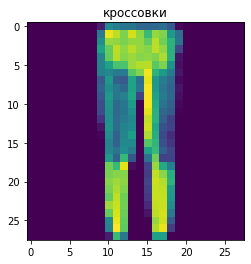

In [23]:
def encode_to_text(n):
    dict = {
        0: 'футболка',
        1: 'брюки',
        2: 'свитер',
        3: 'платье',
        4: 'куртка',
        5: 'сандалии',
        6: 'рубашка',
        7: 'кроссовки',
        8: 'сумка',
        9: 'ботинки',
            }
    return dict[n]
  
n = 3
plt.imshow(test_imagesi[n,:,:])
plt.title(encode_to_text(y_class[n]))
plt.show()

#### Сделаем цикл тренировки модели

In [24]:

# Train the model.
model.fit(  
  train_images[:,:],

  y_t[:,:],
  epochs=15,
  batch_size=32, validation_split=0.2
)

Epoch 1/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6750 - accuracy: 0.7943 - val_loss: 0.4997 - val_accuracy: 0.8270
Epoch 2/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4481 - accuracy: 0.8471 - val_loss: 0.4530 - val_accuracy: 0.8422
Epoch 3/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3974 - accuracy: 0.8608 - val_loss: 0.4165 - val_accuracy: 0.8578
Epoch 4/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3661 - accuracy: 0.8724 - val_loss: 0.4041 - val_accuracy: 0.8586
Epoch 5/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3426 - accuracy: 0.8796 - val_loss: 0.3982 - val_accuracy: 0.8624
Epoch 6/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3302 - accuracy: 0.8830 - val_loss: 0.3789 - val_accuracy: 0.8716
Epoch 7/15
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3146 - accuracy: 0.8877 - val_loss: 0.3687 - val_accuracy:

In [25]:
# Evaluate the model.
model.evaluate( 
  test_images,
  y_tt
)

# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
y_predict = np.argmax(predictions, axis=1)
print(y_predict)

# Check our predictions against the ground truths.
print(test_labels[:5])

313/313 [==============================] - 0s 937us/step - loss: 0.3985 - accuracy: 0.8713
[9 2 1 1 6]
[9 2 1 1 6]


In [26]:
# Дополнительный цикл обучения
model.fit(
  train_images,
  y_t,
  epochs=3,
  batch_size=1024, validation_split=0.2, verbose=0
)

In [27]:
# сохранить веса модели.
# model.save_weights('model.h5')

# загрузить веса модели:
# model.load_weights('model.h5')

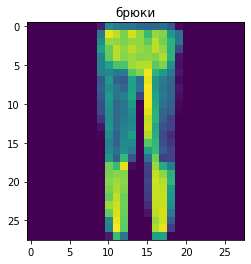

In [28]:
n = 3
plt.imshow(test_imagesi[n,:,:])
plt.title(encode_to_text(y_predict[n]))
plt.show()

### **Зависимость от числа нейронов в слое (для 2-хслойной сети)**

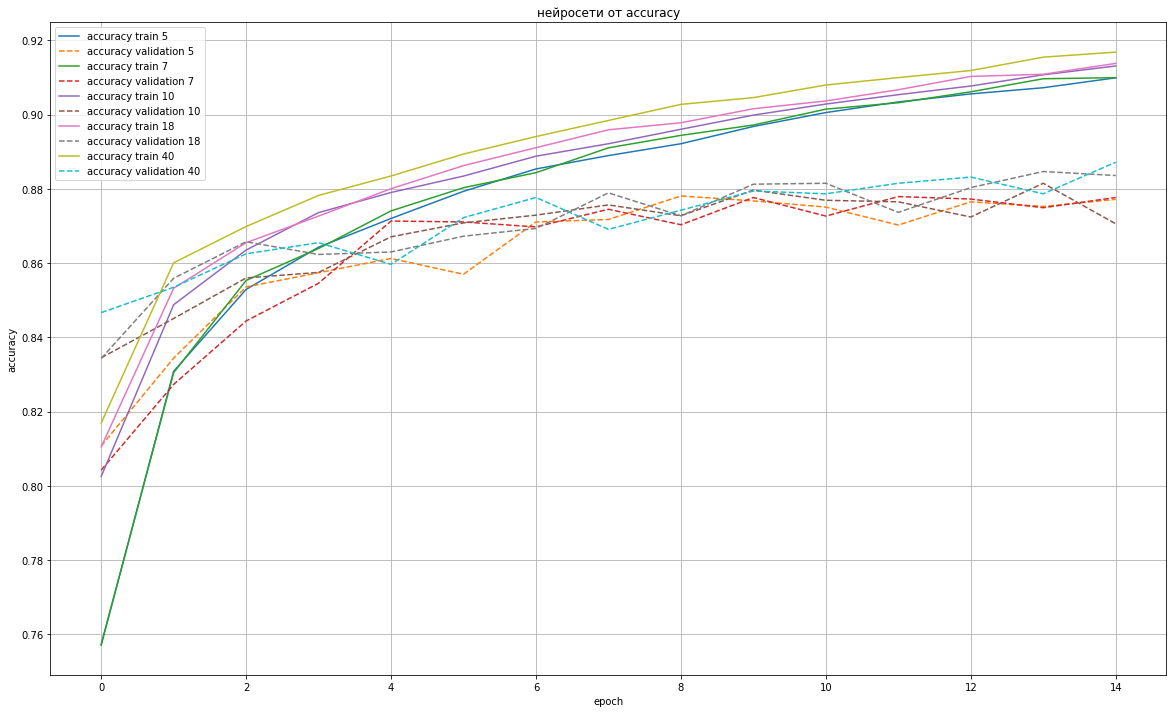

In [31]:
neuron_numb = [5, 7, 10, 18, 40]
plt.figure(figsize=(20,12))
for n in neuron_numb:
    model = Sequential(name='2_layer_model')
    model.add(Dense(128, activation='relu', input_shape=(784,)))  

    model.add(Dense(n, activation='tanh')) 

    model.add(Dense(10, activation='softmax')) 

    # Компилируем сеть с оптимизатором Adam (нам на данный момент интересно влияние количества нейронов), функцией потерь и метрикой:
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(),
        metrics=['accuracy'],
    ) 
    model_history = model.fit(
        train_images[:,:],
        y_t[:,:],
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
#     model.evaluate(
#         test_images,
#         y_tt
#     )

#     predictions = model.predict(test_images[:5])

#     y_predict = np.argmax(predictions, axis=1)
    plt.plot(model_history.history['accuracy'], '-', label = f'accuracy train {n}')
    plt.plot(model_history.history['val_accuracy'], '--', label = f'accuracy validation {n}')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Вывод: качество нейронной сети не слишком зависит от числа нейронов без изменения числа слоев и при достаточном количестве эпох.

### **Зависимость от числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров). Для того, чтобы число параметров было примерно одинаковым, возьмем в качестве neuron_numb константу, равную 30, а число нейронов в слое - число нейронов / число слоев.**

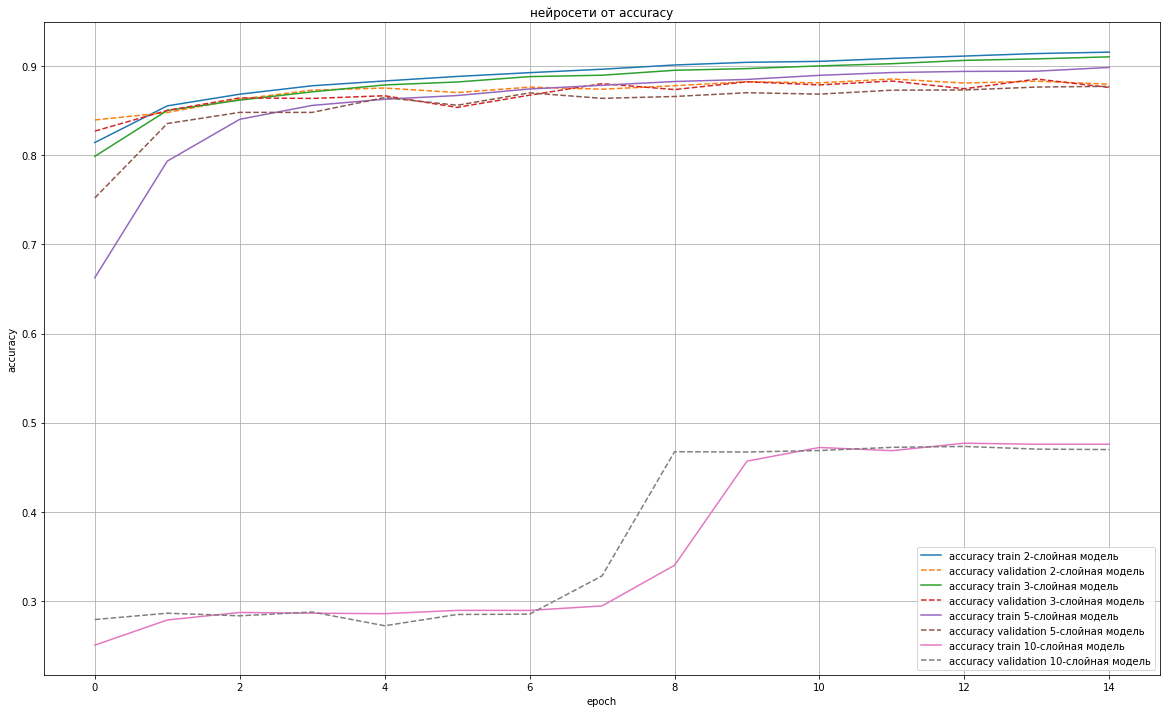

In [33]:
neuron_numb = 30
layers_numb = [2, 3, 5, 10]
plt.figure(figsize=(20,12))
for layers in layers_numb:
    model_l = Sequential(name=f'{layers}_layer_model')
    model_l.add(Dense(128, activation='relu', input_shape=(784,)))  

    for k in range(layers-1):
        model_l.add(Dense(neuron_numb / (layers-1), activation='tanh')) 

    model_l.add(Dense(10, activation='softmax'))
    
    if layers == 3:
        model_l.save_weights('model.l3') # сохраним для задания №2
#         print(model_l.summary())

    model_l.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(),
        metrics=['accuracy'],
    ) 
    model_l_history = model_l.fit(
        train_images[:,:],
        y_t[:,:],
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    plt.plot(model_l_history.history['accuracy'], '-', label = f'accuracy train {layers}-слойная модель')
    plt.plot(model_l_history.history['val_accuracy'], '--', label = f'accuracy validation {layers}-слойная модель')
        
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### Вывод: большое количество слоев (при сравнимом числе тренируемых параметров) негативно влияет на качество сети.

## 2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

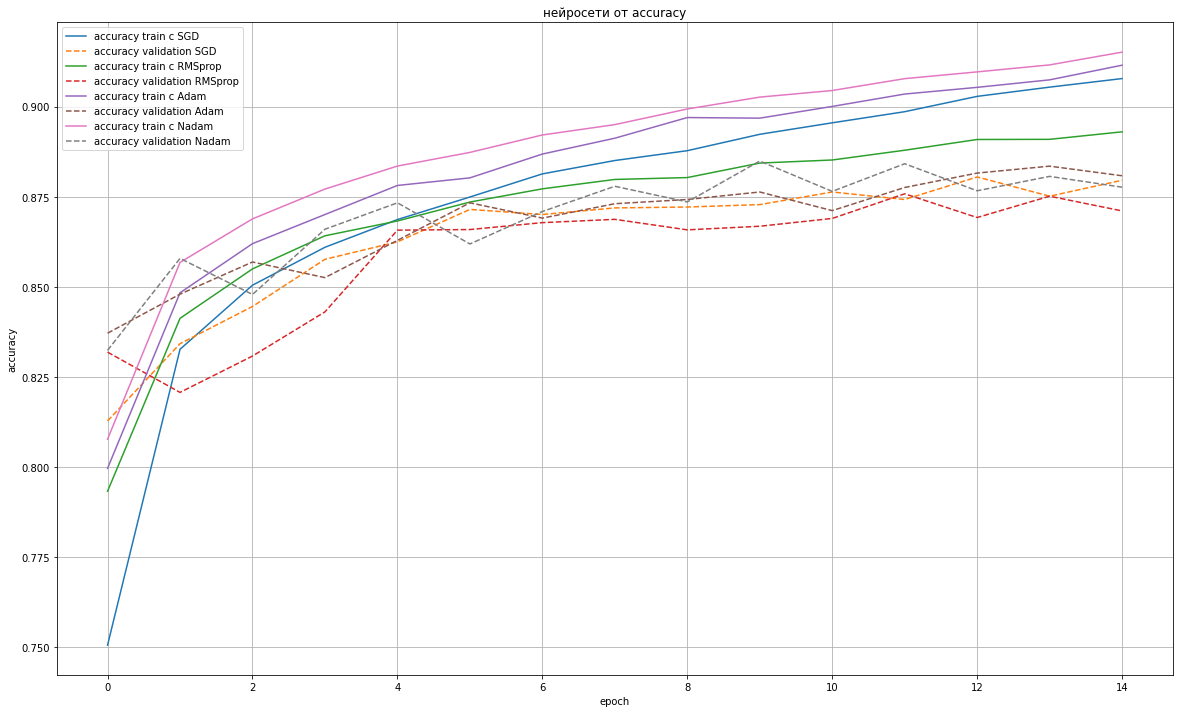

In [36]:
plt.figure(figsize=(20,12))

# число рабочих эпох
epochs = 15
# вектор для выводв результатов
epoch = np.arange(epochs+1)

for i_optim in [SGD(), RMSprop(), Adam(), Nadam()]:
  # создаем рабочую модель modeli куда будем загружать веса из предыдущего задания. Параметры сети - 3 слоя (2 скрытых по 15 нейронов)
    modeli = Sequential(name=f'{i_optim.get_config()["name"]}_layer_model')
    modeli.add(Dense(128, activation='relu', input_shape=(784,)))  

    for k in range(2):
        modeli.add(Dense(15, activation='tanh')) 

    modeli.add(Dense(10, activation='softmax'))
#     print(modeli.summary())
    
  # загружаем веса modeli.load_weights('model.h5')
    modeli.load_weights('model.l3')

  # компилируем modeli с одним из оптимизаторов
    modeli.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )

    modeli_history = modeli.fit(
                  train_images,
                  to_categorical(train_labels),
                  epochs=epochs,
                  batch_size=32, validation_split=0.2, verbose = 0
                  )

    plt.plot(modeli_history.history['accuracy'], '-', label = f'accuracy train с {modeli.optimizer.get_config()["name"]}')
    plt.plot(modeli_history.history['val_accuracy'], '--', label = f'accuracy validation {modeli.optimizer.get_config()["name"]}')
     
plt.legend()
plt.grid('On')
plt.title('нейросети от accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3. Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?

### Качество сети на тестовом наборе помогает улучшить дообучение сети :)
### Если брать парамты, которые мы варьировали, то на нашем примере видно, что выбор оптимизатора не слишком влияет на качество сети, как и количество нейронов в двухслойной сети. А вот уменьшение количества слоев дает прибавку к качеству.

## 4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

In [38]:
neuron_numb = 20

model = Sequential(name='3_layer_model')
model.add(Dense(128, activation='relu', input_shape=(784,)))  
model.add(Dense(neuron_numb / 2, activation='tanh')) 
model.add(Dense(neuron_numb / 2, activation='tanh'))
model.add(Dense(10, activation='softmax')) 

model.compile(
  optimizer='nadam',
  loss=CategoricalCrossentropy(), # функция потерь
  metrics=['accuracy'],
) 

model.fit(  
    train_images[:,:],
    y_t[:,:],
    epochs=15,
    batch_size=32, validation_split=0.2, verbose=0
)

In [39]:
model.evaluate( 
  test_images,
  y_tt
)

predictions = model.predict(test_images)

y_predict = np.argmax(predictions, axis=1)
print(y_predict[:50])

print(test_labels[:50])

313/313 [==============================] - 1s 2ms/step - loss: 0.4076 - accuracy: 0.8640
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 2 8 0 2 7 7 5 1 2 6 0 9 4 8 8 3 3 8 0 7
 5 7 9 0 1 6 9 6 9 2 1 4 6]
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2]


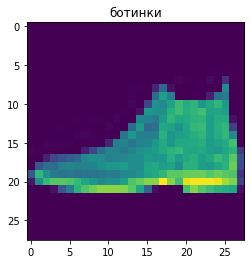

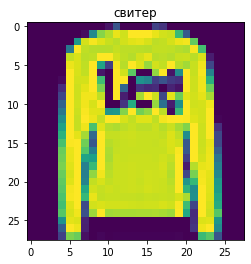

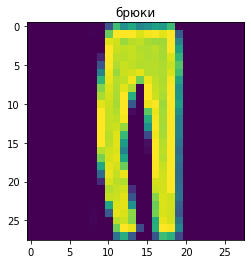

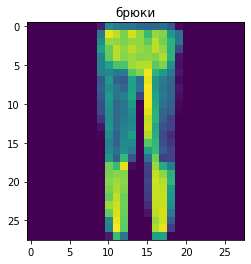

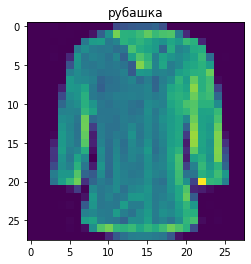

In [40]:
for n in range(5):
    plt.imshow(test_imagesi[n,:,:])
    plt.title(encode_to_text(y_predict[n]))
    plt.show()

In [41]:
# test_labels = pd.Series(test_labels, name='Actual')
# y_predict = pd.Series(y_predict, name='Predicted')
# df_confusion = pd.crosstab(test_labels, y_predict)
cnf_matrix = confusion_matrix(test_labels, y_predict)

In [42]:
cnf_matrix

array([[770,   5,  11,  32,   7,   0, 165,   0,  10,   0],
       [  0, 974,   0,  18,   4,   0,   2,   0,   2,   0],
       [ 18,   2, 785,   6, 128,   1,  56,   0,   4,   0],
       [ 14,  15,  16, 848,  71,   0,  29,   0,   7,   0],
       [  1,   0,  99,  14, 838,   0,  46,   0,   2,   0],
       [  0,   0,   0,   0,   0, 928,   0,  25,  22,  25],
       [ 84,   4,  87,  31, 113,   0, 666,   0,  15,   0],
       [  0,   0,   0,   0,   0,  19,   0, 920,  10,  51],
       [  5,   0,   7,   5,  11,   1,  18,   4, 949,   0],
       [  1,   0,   0,   0,   0,   8,   0,  29,   0, 962]])

In [43]:
TP = np.diag(cnf_matrix)
TP

array([770, 974, 785, 848, 838, 928, 666, 920, 949, 962])

In [44]:
FP = np.sum(cnf_matrix, axis=0) - TP
FP

array([123,  26, 220, 106, 334,  29, 316,  58,  72,  76])

In [45]:
FN = np.sum(cnf_matrix, axis=1) - TP
FN

array([230,  26, 215, 152, 162,  72, 334,  80,  51,  38])

In [46]:
num_classes = 10
TN = []
for i in range(num_classes):
    temp = np.delete(cnf_matrix, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
TN

[8877, 8974, 8780, 8894, 8666, 8971, 8684, 8942, 8928, 8924]

In [47]:
for i in range(num_classes):
    print(TP[i] + FP[i] + FN[i] + TN[i])

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [48]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f = 2 * (precision * recall) / (precision + recall)

In [49]:
metrics = pd.DataFrame({'precision': precision, 'recall': recall, 'f1-score': f})

In [50]:
metrics

,precision,recall,f1-score
0,0.862262,0.770,0.813524
1,0.974000,0.974,0.974000
2,0.781095,0.785,0.783042
3,0.888889,0.848,0.867963
4,0.715017,0.838,0.771639
5,0.969697,0.928,0.948390
6,0.678208,0.666,0.672048
7,0.940695,0.920,0.930233
8,0.929481,0.949,0.939139
9,0.926782,0.962,0.944063


In [51]:
metrics.to_csv('metrics')

In [53]:
report = classification_report(test_labels, y_predict)
with open ('report.txt', 'w') as w:
    w.write(report)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       0.97      0.97      0.97      1000
           2       0.78      0.79      0.78      1000
           3       0.89      0.85      0.87      1000
           4       0.72      0.84      0.77      1000
           5       0.97      0.93      0.95      1000
           6       0.68      0.67      0.67      1000
           7       0.94      0.92      0.93      1000
           8       0.93      0.95      0.94      1000
           9       0.93      0.96      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



### Судя по метрикам, модель получилась достаточно хорошей. Проблема только с определением рубашек, но они и правда не очень четкие.